In [1449]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
import statsmodels.tsa.stattools as ts
from numpy import cumsum
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from scipy.signal import periodogram
import warnings
warnings.filterwarnings('ignore')

In [1450]:
c

,Revenue
Day,
1,0.000000
2,-0.292356
3,-0.327772
4,-0.339987
5,-0.124888


In [1451]:
df.describe()

,Revenue
count,731.000000
mean,14.179608
std,6.959905
min,-4.423299
25%,11.121742
50%,15.951830
75%,19.293506
max,24.792249


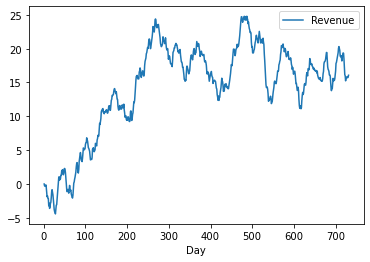

ADF Statistic: -2.2183190476089445
p-value: 0.19966400615064384


In [1452]:
result = adfuller(df['Revenue'])

# Plot the time series
fig, ax = plt.subplots()
df.plot(ax=ax)
plt.show()

# Print the test statistic and the p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])

In [1453]:
# This data does not appear to be stationary - there is an initial trend. The ADF statistic is not very negative and the p-value is above 0.05.

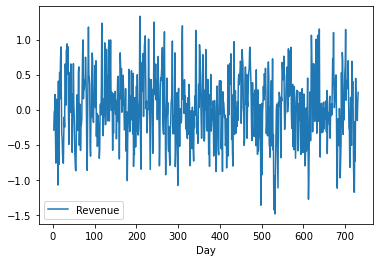

ADF Statistic: -17.374772303557062
p-value: 5.113206978840171e-30
p-value rounded: 0.0


In [1454]:
# Difference data and plot it
df_stationary = df.diff().dropna()
fig, ax = plt.subplots()
df_stationary.plot(ax=ax)
plt.show()

# Print the test statistic and the p-value
result = adfuller(df_stationary['Revenue'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('p-value rounded:', round(result[1]))

In [1455]:
# ADF is very negative and p-value is approximiately 0, so this is now stationary.

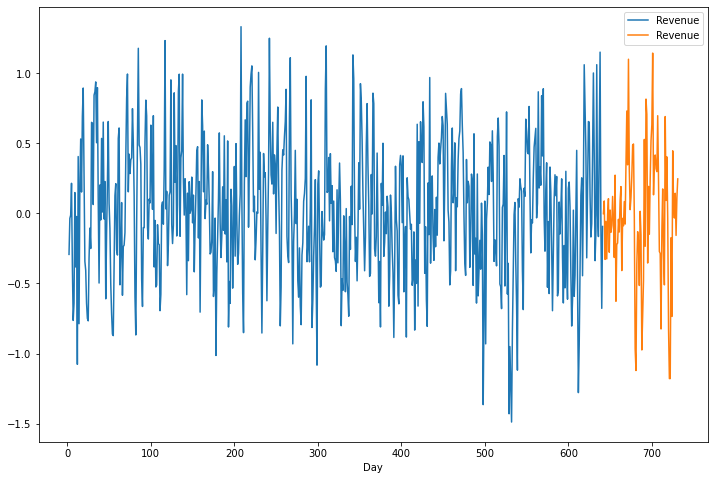

In [1456]:
# Split the data into a train and test set
stationary_train = df_stationary.loc[:'641']
stationary_test = df_stationary.loc['642':]
train_df = df.loc[:'641']
test_df = df.loc['642':]

# Plot the train and test sets
fig, ax = plt.subplots(figsize=(12,8))
stationary_train.plot(ax=ax)
stationary_test.plot(ax=ax)
plt.show()


In [1457]:
# A visual inspection tells us there is likely no seasonality in this data, but let's plot the ACF and PACF to confirm.

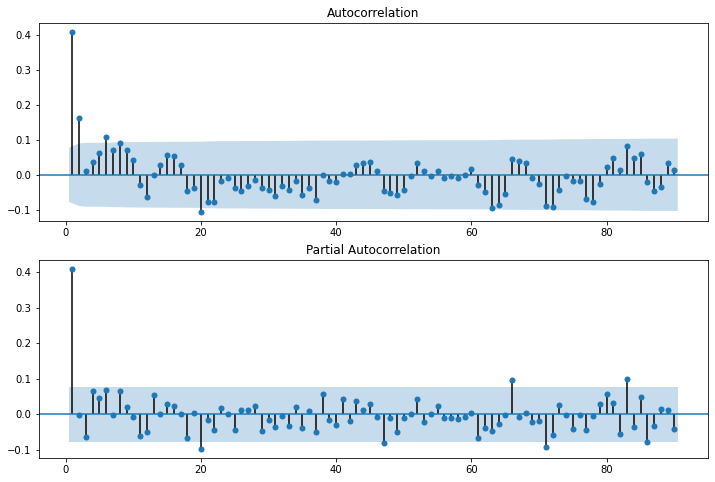

In [1458]:
# Plot the ACF and PACF
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))

plot_acf(stationary_train, lags=90, zero=False, ax=ax1)

plot_pacf(stationary_train, lags=90, zero=False, ax=ax2)
plt.show()

In [1459]:
# It does not appear that there is seasonality here.

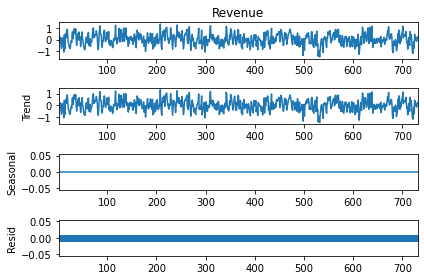

In [1460]:
# Perform additive decomposition
decomp = seasonal_decompose(df_stationary['Revenue'],
                            period=1)

# Plot decomposition
decomp.plot()
plt.show()

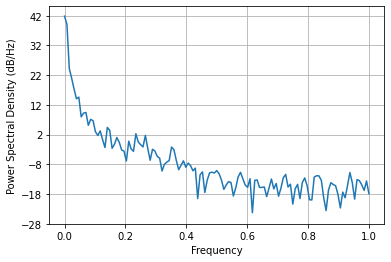

In [1461]:
#Spectral density
plt.psd(df['Revenue']);

In [1462]:
# Can't deduce p and q from ACF and PACF plots

In [1463]:
# Run AIC and BIC test to determine p and q values
order_aic_bic=[]

for p in range(3):
    for q in range(3):
        model = SARIMAX(train_df['Revenue'], order=(p,1,q))
        results = model.fit()
        order_aic_bic.append((p,q,results.aic, results.bic))

In [1464]:
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p', 'q', 'AIC', 'BIC'])

# Print order_df in order of increasing AIC
order_df.sort_values('AIC')

,p,q,AIC,BIC
2,0,2,780.539431,793.923836
3,1,0,782.502481,791.425417
5,1,2,782.516174,800.362047
8,2,2,784.028225,806.335566
7,2,1,784.107487,801.953360
6,2,0,784.500072,797.884476
4,1,1,784.500644,797.885049
1,0,1,802.569182,811.492118
0,0,0,898.189049,902.650517


In [1465]:
# Our best ARIMA models appear to be:
# (0, 1, 2)
# (1, 1, 2)
# (1, 1, 0)
# (2, 1, 2)
# (2, 1, 1)
# (2, 1, 0)
# (1, 1, 1)
# Let's use the auto.arima function further 

In [1466]:
auto_arima_fit = auto_arima(train_df, 
                            start_p=0,
                           start_q=0,
                           max_p=3,
                           max_q=3,
                           m=1,
                           seasonal=False,
                           d=1,
                           D=1,
                           trace=True,
                           error_action='ignore', 
                           suppress_warnings=True,
                           stepwise=True)

auto_arima_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=898.135, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=783.667, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=803.257, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=898.189, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=785.660, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=785.662, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=785.306, Time=0.59 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=782.502, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=784.500, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=784.501, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=802.569, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=784.107, Time=0.24 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.874 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  641
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -389.251
Date:                Tue, 28 Dec 2021   AIC                            782.502
Time:                        14:32:12   BIC                            791.425
Sample:                             0   HQIC                           785.966
                                - 641                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4096      0.037     11.183      0.000       0.338       0.481
sigma2         0.1975      0.012     16.551      0.000       0.174       0.221
===================================================================================
Ljung-Box (Q):                       45.03   Jarque-Bera (JB):                 2.17
Prob(Q):                              0.27   Prob(JB):                         0.34
Heteroskedasticity (H):               1.03   Skew:                            -0.02
Prob(H) (two-sided):                  0.83   Kurtosis:                         2.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

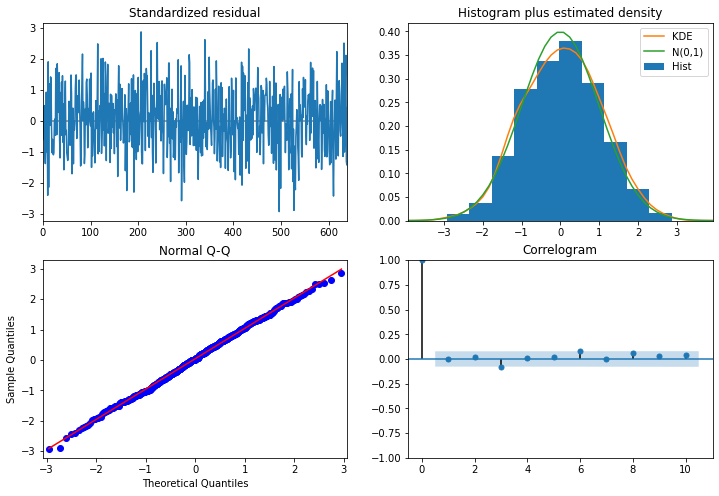

In [1467]:
auto_arima_fit.plot_diagnostics(figsize=(12,8))
plt.show();

In [1468]:
# The auto_arima tools says our best model is (1, 1, 0)
# Let's try out the others that got low AIC and BIC scores

In [1469]:
model110 = SARIMAX(train_df, order=(1, 1, 0))
model_fit110 = model110.fit()
print(model_fit110.summary())

model012 = SARIMAX(train_df, order=(0, 1, 2))
model_fit012 = model012.fit()
print(model_fit012.summary())

model112 = SARIMAX(train_df, order=(1,1,2))
model_fit112 = model112.fit()
print(model_fit112.summary())

model212 = SARIMAX(train_df, order=(2,1,2))
model_fit212 = model212.fit()
print(model_fit212.summary())

model211 = SARIMAX(train_df, order=(2,1,1))
model_fit211 = model211.fit()
print(model_fit211.summary())

model210 = SARIMAX(train_df, order=(2,1,0))
model_fit210 = model210.fit()
print(model_fit210.summary())

model111 = SARIMAX(train_df, order=(1,1,1))
model_fit111 = model111.fit()
print(model_fit111.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  641
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -389.251
Date:                Tue, 28 Dec 2021   AIC                            782.502
Time:                        14:32:17   BIC                            791.425
Sample:                             0   HQIC                           785.966
                                - 641                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4096      0.037     11.183      0.000       0.338       0.481
sigma2         0.1975      0.012     16.551      0.000       0.174       0.221
Ljung-Box (Q):                       45.03   Jarque-

In [1470]:
# MAKE FINAL DETERMINATION BASED ON.......
# If either Prob(Q) or Prob(JB) is less than 0.05, bad model
# Let's go with the one picked by the auto arima function

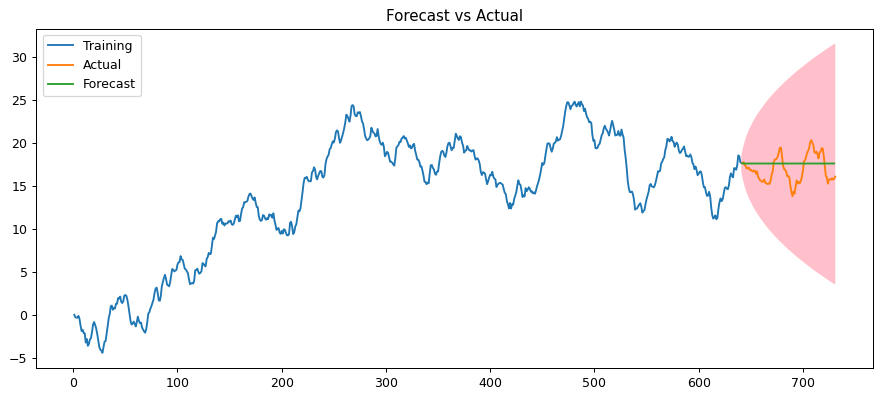

In [1471]:
# WE HAVE CHOSEN A (1,1,0) MODEL
# Create and train model
model = SARIMAX(train_df, order=(1,1,0))
results = model.fit()

# Forecast
train_forecast = results.forecast(90)

# Make as pandas series
forecast_series = pd.Series(train_forecast, index=test_df.index)

# Confidence intervals
forecast = results.get_forecast(90)
yhat = forecast.predicted_mean
confidence = forecast.conf_int(alpha=0.05)
lower_limits = confidence.loc[:,'lower Revenue']
upper_limits = confidence.loc[:,'upper Revenue']

# Plot
plt.figure(figsize=(12,5), dpi=90)
plt.plot(train_df, label='Training')
plt.plot(test_df, label='Actual')
plt.plot(forecast_series, label='Forecast')
plt.fill_between(lower_limits.index, lower_limits, 
               upper_limits, color='pink')

plt.title('Forecast vs Actual')
plt.legend(loc='upper left')
plt.show()

In [1472]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  641
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -389.251
Date:                Tue, 28 Dec 2021   AIC                            782.502
Time:                        14:32:23   BIC                            791.425
Sample:                             0   HQIC                           785.966
                                - 641                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4096      0.037     11.183      0.000       0.338       0.481
sigma2         0.1975      0.012     16.551      0.000       0.174       0.221
Ljung-Box (Q):                       45.03   Jarque-

In [1473]:
train_forecast

641    17.617750
642    17.602144
643    17.595751
644    17.593133
645    17.592060
         ...    
726    17.591316
727    17.591316
728    17.591316
729    17.591316
730    17.591316
Length: 90, dtype: float64

In [1474]:
# Mean squared error
from sklearn.metrics import mean_squared_error, mean_absolute_error

print({'Mean Squared Error':mean_squared_error(test_df, train_forecast)})
print({'Mean Absolute Error':mean_absolute_error(test_df, train_forecast)})
mape = np.mean(np.abs(train_forecast - test_df['Revenue'])/np.abs(test_df['Revenue']))
print({'Mean Absolute Percentage Error':mape})
rmse = np.mean((train_forecast - test_df['Revenue'])**2)**.5
print({'Root Mean Squared Error':rmse})
mpe = np.mean((train_forecast - test_df['Revenue'])/test_df['Revenue'])
print({'Mean Percentage Error':mpe})

{'Mean Squared Error': 2.8549298682099993}
{'Mean Absolute Error': 1.4768522728867641}
{'Mean Absolute Percentage Error': 0.09015135408204893}
{'Root Mean Squared Error': 1.691447424251677}
{'Mean Percentage Error': 0.04681211639632951}


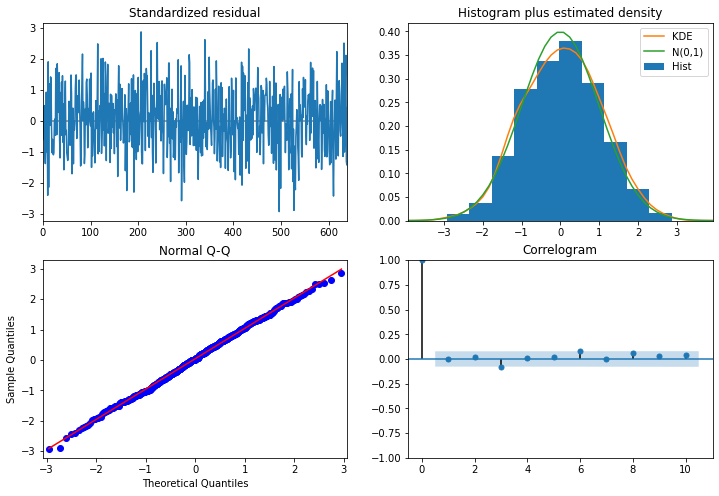

In [1475]:
results.plot_diagnostics(figsize=(12,8))
plt.show()

In [1476]:
# Test	Good fit
# Standardized residual	There are no obvious patterns in the residuals
# Histogram plus kde estimate	The KDE curve should be very similar to the normal distribution
# Normal Q-Q	Most of the data points should lie on the straight line
# Correlogram	95% of correlations for lag greater than zero should not be significant

In [1477]:
# Make Future Predictions
model = SARIMAX(df, order=(1,1,0))
results = model.fit()

In [1478]:
# Create forecast object
forecast_object = results.get_forecast(steps=90, dynamic=True)

# Extract prediction mean
mean = forecast_object.predicted_mean

# Extract the confidence intervals
conf_int = forecast_object.conf_int()

# Extract the forecast dates
dates = mean.index

# Select lower and upper confidence limits
lower_limits = conf_int.loc[:,'lower Revenue']
upper_limits = conf_int.loc[:,'upper Revenue']

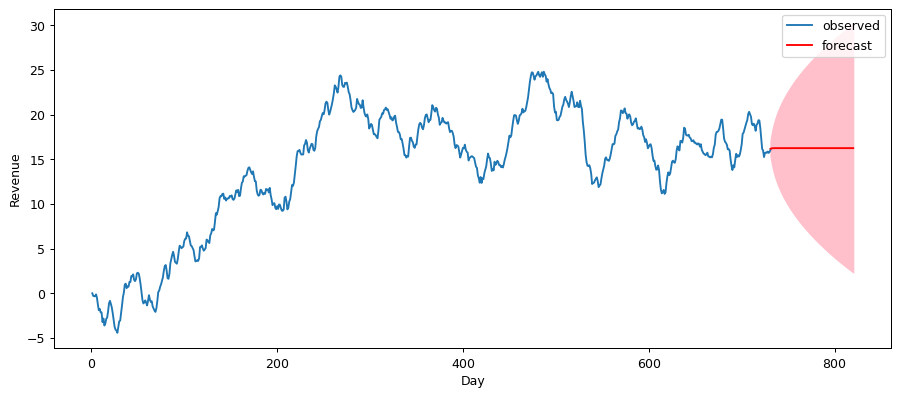

In [1479]:
# plot the data
plt.figure(figsize=(12,5), dpi=90)
plt.plot(df.index, df, label='observed')
plt.plot(dates, mean, color='r', label='forecast')
plt.fill_between(lower_limits.index, lower_limits, 
               upper_limits, color='pink')

plt.xlabel('Day')
plt.ylabel('Revenue')
plt.legend()
plt.show()

In [1480]:
mean

731    16.171557
732    16.213858
733    16.231380
734    16.238637
735    16.241643
         ...    
816    16.243769
817    16.243769
818    16.243769
819    16.243769
820    16.243769
Length: 90, dtype: float64

In [1481]:
print(conf_int)

     lower Revenue  upper Revenue
731      15.307542      17.035571
732      14.717347      17.710370
733      14.202390      18.260370
734      13.755479      18.721796
735      13.362614      19.120673
..             ...            ...
816       2.662033      29.825505
817       2.582180      29.905358
818       2.502791      29.984747
819       2.423859      30.063679
820       2.345374      30.142164

[90 rows x 2 columns]
